The file does two tasks:
1) Runs over the NanoAOD files using coffea and the processor in `CoffeaJERCProcessor_L5.py`, and creates the histograms of jet reponses and reco jet $p_T$. Stores the result in outname='out/CoffeaJERCOutputs'tag_Lx+'_'+data_tag+add_tag'.coffea'
2) Fits the response histograms (or calculates the medians) and creates the `txt` files with the fit results (one fle for each `Mean`, `MeanVar`, `Median`, `MedianStd`, `MeanRecoPt`)

It is possible to bypass the (usually long) part 1) by applying `load_preexisting = True`. In such case, a file with `outname` will be read and then the histograms refit.
Options for running on condor, coffea Case using dask are available. See, under `Parameters of the run and switches`.

At the moment, for producing the flavor uncertatinties, for obtaining the results over the 6 datasets neccessary, the script has to be once for each of them (QCD stiching is done automatically) as dask+condor is still sometimes unstable, but this can be united in the future.

# Dask Setup:
---
### For Dask+Condor setup on lxplus
#### 1.) The wrapper needs to be installed following https://github.com/cernops/dask-lxplus
#### 2.) Source lcg environment in bash
#### `source /cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/latest/x86_64-centos7-gcc11-opt/setup.sh`
#### Singularity could work but not confirmed.
---
### For Coffea-Casa, the client must be specified according to the user that is logged into the Coffea-Casa Environment.
#### 1.) go to the left of this coffea-casa session to the task bar and click the orange-red button; it will say "Dask" if you hover your cursor over it
#### 2.) scroll down to the blue box where it shows the "Scheduler Address"
#### 3.) write that full address into the dask Client function 
#### Example: `client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")`
---
### For CMSLPC, the client must be specified with the LPCCondorCluster
#### 1.) follow installation instructions from https://github.com/CoffeaTeam/lpcjobqueue, if you have not already done so, to get a working singularity environment with access to lpcjobqueue and LPCCondorCluster class
#### 2.) import LPCCondorCluster: `from lpcjobqueue import LPCCondorCluster`
#### 3.) define the client
#### Example: 
`cluster = LPCCondorCluster()`

`client = Client(cluster)`


### My favorite notebook settings

In [54]:
## Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%load_ext autoreload
## Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading (though this does not work for me :()

## Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

### Imports

In [55]:
import sys
coffea_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/'
if coffea_path not in sys.path:
    sys.path.insert(0,coffea_path)

ak_path = '/afs/cern.ch/user/a/anpotreb/top/JERC/local-packages/'

if ak_path not in sys.path:
    sys.path.insert(0,ak_path)

In [56]:
import time
import scipy.stats as ss
from coffea import processor, util
from coffea.nanoevents import NanoAODSchema, BaseSchema

import numpy as np
from numpy.random import RandomState
import importlib

# import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import hist

from plotters.pltStyle import pltStyle
pltStyle(style='hep')
# pltStyle(style='paper')
plt.rcParams['figure.dpi'] = 150
import os

### import subpackages
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import save_data, read_data, get_median, gauss, slice_histogram, add_flavors, fit_response
from plotters.plotters import plot_response_dist, plot_corrections, plot_corrections_eta

from helpers import rebin_hist, mirror_eta_to_plus, sum_neg_pos_eta, find_ttbar_xsec
from common_binning import JERC_Constants
# %matplotlib notebook 

### Parameters of the run and switches

In [57]:
UsingDaskExecutor = True   ### True if use dask local executor, otherwise use futures
CERNCondorCluster = False   ### True if run on the CERN condor cluster using dask. Requires `UsingDaskExecutor` = True
CoffeaCasaEnv     = False   ### True if run on coffea case. Never tested since ages.
load_preexisting  = True    ### True if don't repeat the processing of files and use preexisting JER from output
test_run          = False   ### True if run only on one file and five chuncs to debug processor
load_fit_res      = False   ### True if only replot the fit results

### If True use JERC default binning, if False, merge bins into the Run 1 binning (binning in HCal sectors) 
### Preprocessing always done in many bins
fine_etabins      = False   
one_bin           = False   ### Unite all eta and pt bins in one

Nfiles = -1                 ### -1 for all files

tag_Lx = '_L5'                 ### L5 or L23, but L23 not supported since ages.

### Define the dataset either by using a `data_tag` available in `dataset_dictionary`
### Or manualy by defining `dataset` (below) with the path to the .txt file with the file names (without the redirectors).
### Or manually by defining `fileslist` as the list with file names.
### data_tag will be used to name output figures and histograms.
data_tag = 'Pythia-TTBAR' 
# data_tag = 'DY-FxFx'
### name of the specific run if parameters changed used for saving figures and output histograms.
add_tag = '' #_Aut18binning   

certificate_dir = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

# fileslist = ['root://xrootd-cms.infn.it/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/2510000/056516']

In [58]:
tag_full = tag_Lx+'_'+data_tag+add_tag

### Dataset parameters

In [59]:
dataset = None
dataset='fileNames/TTToSemi20UL18_JMENano.txt'
fileslist = None

dataset_dictionary = {
    "Pythia-TTBAR": 'fileNames/TTToSemi20UL18_JMENano.txt',
    "Herwig-TTBAR": 'fileNames/TT20UL18_JMENano_Herwig.txt',
    "DY-MG-Py":     'fileNames/DYJets_MG-Py.txt',
    "DY-MG-Her":    'fileNames/DYJets_MG-Her.txt',
    "QCD-MG-Py":    'fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt',
    "QCD-MG-Her":   'fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt',
    "QCD-Py":       'fileNames/QCD20UL18_JMENano.txt',
    "DY-FxFx":      'fileNames/DYJets.txt',
}

if 'QCD' in 'data_tag':
    print('Alpha cut of $\alpha<0.2$ will be used and a cut on three leading jets')
else:
    print('No alpha cut and cut on the leading jets will be used')
    

if not (fileslist is None):
    print(f'A specific fileslist specified. The calculation will be run on the files {fileslist}')
elif data_tag in dataset_dictionary.keys():
    dataset = dataset_dictionary[data_tag]
    print(f'The data tag "{data_tag}" found in the dataset_dictionary. The dataset "{dataset}" will be used.')
elif not(dataset is None):
    print(f'Using the provided dataset "{dataset}" and the data tag "{data_tag}".')
else:
    raise ValueError(f'The data tag "{data_tag}" not found in the dataset_dictionary and no dataset provided.')
    

No alpha cut and cut on the leading jets will be used
The data tag "Pythia-TTBAR" found in the dataset_dictionary. The dataset "fileNames/TTToSemi20UL18_JMENano.txt" will be used.


In [60]:
### Choose the correct redirector
## assume running on the LPC
# xrootdstr = 'root://cmsxrootd.fnal.gov/'
## assume running on the lxplus
# xrootdstr = 'root://cms-xrd-global.cern.ch//'
xrootdstr = 'root://xrootd-cms.infn.it/'

# if running on coffea casa instead...
if CoffeaCasaEnv:
    xrootdstr = 'root://xcache/'

### Do some logic with the input partameters and the rest of parameters of the run

In [61]:
#Import the correct processor
Processor = importlib.import_module('CoffeaJERCProcessor'+tag_Lx).Processor
# Processor = importlib.import_module('GetAlphaDristributionProcessor').Processor

tag_full = tag_Lx+'_'+data_tag+add_tag
if test_run:
    tag_full = tag_full+'_test'
outname = 'out/CoffeaJERCOutputs'+tag_full+'.coffea'

tag_fit_res = tag_full

if fine_etabins:
    tag_fit_res=tag_full+'_fine_etaBins'

if one_bin:
    tag_fit_res=tag_fit_res+'_oneBin'
    
if load_preexisting == True:
    UsingDaskExecutor = False
    
if UsingDaskExecutor == False:
    CERNCondorCluster = False
    
if not os.path.exists("out"):
    os.mkdir("out")
    
if not os.path.exists("out_txt"):
    os.mkdir("out_txt")
    
if not os.path.exists("fig"):
    os.mkdir("fig/")
    os.mkdir("fig/responses/")
    
if test_run and not os.path.exists("test"):
    os.mkdir("test/")
    os.mkdir("test/out_txt")
    os.mkdir("test/fig")
    
maxchunks = 100 if test_run else None
if test_run:
    Nfiles = 1

print(f'Running on the number of files: {Nfiles}\n Job with the full tag {tag_full}\n Outname = {outname}')


Running on the number of files: -1
 Job with the full tag _L5_Pythia-TTBAR
 Outname = out/CoffeaJERCOutputs_L5_Pythia-TTBAR.coffea


In [62]:
def txt2filesls(dataset_name):
    with open(dataset_name) as f:
        rootfiles = f.read().split()
        fileslist = [xrootdstr + file for file in rootfiles]
    return fileslist

### For the attempt to correctly combine three ttbar channels. Not fully tested

In [63]:
combineTTbar = False
ttbar_tags = ['Semi', 'Dilep', 'Had']

filesets = {}
if not (fileslist is None):
    xsec_dict = {data_tag: 1}
    filesets = {data_tag: {"files": fileslist, "metadata": {"xsec": 1}}}
elif combineTTbar:
    for ftag in ttbar_tags:
        data_name = f'fileNames/fileNames_TTTo{ftag}20UL18_JMENano.txt'
        fileslist = txt2filesls(data_name)[:Nfiles]
        xsec = find_ttbar_xsec(data_name)
        filesets[ftag] = {"files": fileslist, "metadata": {"xsec": xsec}}
elif "QCD-MG" in data_tag:
    ### if dataset striched together from a set of datasets where the cross-section for each is given in `dataset`
    dataset_path = '/'.join(dataset.split('/')[:-1])
    with open(dataset) as f:
        lines = f.readlines()
    lines_split = [line.split() for line in lines]
    if test_run:
        lines_split = lines_split[:3]  
    xsec_dict = {data_tag+'_'+lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    file_dict = {data_tag+'_'+lineii[1]: lineii[0] for lineii in lines_split }
    for key in file_dict.keys():
        data_name = file_dict[key]
        fileslist = txt2filesls(dataset_path+'/'+data_name)[:Nfiles]
        filesets[key] = {"files": fileslist, "metadata": {"xsec": xsec_dict[key]}}
    
else:
    fileslist = txt2filesls(dataset)[:Nfiles]
    #### If manyally adding fileslist
    xsec_dict = {data_tag: 1}
    filesets = {data_tag: {"files": fileslist, "metadata": {"xsec": 1}}}


Test if certificate works to open the file

In [64]:
### RUN THIS CELL ONLY IF YOU ARE USING SWAN 

##### REMEMBER TO MANUALLY COPY THE PROXY TO YOUR CERNBOX FOLDER AND TO MODIFY THE NEXT LINE
os.environ['X509_USER_PROXY'] = certificate_dir
if os.path.isfile(os.environ['X509_USER_PROXY']):
    print("Found proxy at {}".format(os.environ['X509_USER_PROXY']))
else:
    print("os.environ['X509_USER_PROXY'] ",os.environ['X509_USER_PROXY'])
os.environ['X509_CERT_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/certificates'
os.environ['X509_VOMS_DIR'] = '/cvmfs/cms.cern.ch/grid/etc/grid-security/vomsdir'
os.environ['X509_USER_CERT'] = '/afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem'

env_extra = [
            f'export X509_USER_PROXY={certificate_dir}',
            f'export X509_CERT_DIR={certificate_dir}',
        ]

Found proxy at /afs/cern.ch/user/a/anpotreb/k5-ca-proxy.pem


In [65]:
if not load_preexisting:
    import uproot
    ff = uproot.open(fileslist[0])
    ff.keys()
    ff.close()

    # print(f"The test file read successfully. All good with certifiates.")

In [66]:
 # Dask set up for Coffea-Casa only
if(UsingDaskExecutor and CoffeaCasaEnv):
    from dask.distributed import Client 
    client = Client("tls://ac-2emalik-2ewilliams-40cern-2ech.dask.coffea.casa:8786")
    client.upload_file('CoffeaJERCProcessor.py')

In [67]:
if(UsingDaskExecutor and not CoffeaCasaEnv):
    from dask.distributed import Client 
 # Dask set up for LPC only 
    if not CERNCondorCluster:
        client = Client()
        client.get_versions(check=True)
#         client.nanny = False

    else:
        from dask_lxplus import CernCluster
        import socket

        cluster = CernCluster(
# #             memory=config.run_options['mem_per_worker'],
# #             disk=config.run_options.get('disk_per_worker', "20GB"),
#             env_extra=env_extra,
            cores = 1,
            memory = '4000MB',
            disk = '2000MB',
            death_timeout = '60',
            lcg = True,
            nanny = False,
            container_runtime = 'none',
            log_directory = '/eos/user/a/anpotreb/condor/log',
            scheduler_options = {
                'port': 8786,
                'host': socket.gethostname(),
            },
            job_extra = {
                'MY.JobFlavour': '"longlunch"',
#                 'transfer_input_files': '/afs/cern.ch/user/a/anpotreb/top/JERC/JMECoffea/count_2d.py',
            },
        )
        cluster.adapt(minimum=2, maximum=200)
        cluster.scale(8)
        client = Client(cluster)
    
    client.upload_file('CoffeaJERCProcessor'+tag_Lx+'.py')
    client.upload_file('GetAlphaDristributionProcessor.py')
    client.upload_file('LHE_flavour.py')
    client.upload_file('common_binning.py')

    client

### Run the processor

In [68]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
chunksize = 10000
# maxchunks = 100

if not load_preexisting:
    if not UsingDaskExecutor:
        chosen_exec = 'futures'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.iterative_executor,
    #                                        executor=processor.futures_executor,
                                          executor_args={
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'workers': 2},
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)
    else:
        chosen_exec = 'dask'
        output = processor.run_uproot_job(filesets,
                                          treename='Events',
                                          processor_instance=Processor(),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'skipbadfiles':True,
                                              'schema': NanoAODSchema, #BaseSchema
                                              'xrootdtimeout': 60,
                                              'retries': 2,
#                                               'workers': 2
                                          },
                                          chunksize=chunksize,
                                          maxchunks=maxchunks)

    elapsed = time.time() - tstart
    print("Processor finished. Time elapsed: ", elapsed)
#     outputs_unweighted[name] = output
    print("Saving the output histograms under: ", outname)
    util.save(output, outname)
#     outputs_unweighted[name] = output
else:
    output = util.load(outname)
    print("Loaded histograms from: ", outname)

#### Attempt to prevent the error when the cluster closes. Doesn't always work.
if UsingDaskExecutor:
    client.close()
    time.sleep(5)
    if CERNCondorCluster or CoffeaCasaEnv:
        cluster.close()

Loaded histograms from:  out/CoffeaJERCOutputs_L5_Pythia-TTBAR.coffea


### Striching up the sample

In [69]:
output_orig = output
if "QCD-MG" in data_tag:
    response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
    scale_factors = hist_div(xsec_dict, response_sums)
    all_histo_keys = output[next(iter(output.keys()))].keys()
    result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
    output = result
elif len(output.keys())==1:
    output = output[list(output.keys())[0]]

### Fit responses

Define some global variables for the fit

In [70]:
# ptbins = output[response_key].axes["pt_gen"].edges 
# ptbins_c = output[response_key].axes['pt_gen'].centers

In [71]:
## find the first response histogram to extract the axes
for key in output.keys():
    if 'response' in key:
        response_key = key
        break

tag_full += '_fineeta' if fine_etabins==True else ''

ptbins = output[response_key].axes["pt_gen"].edges 
ptbins_c = output[response_key].axes['pt_gen'].centers
etabins = output[response_key].axes["jeteta"].edges
if one_bin==True:
    ptbins = np.array([ptbins[0], ptbins[-1]])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([etabins[0], 0, etabins[-1]])
elif not fine_etabins:
    etabins = np.array(JERC_Constants.etaBinsEdges_Aut18_full())
#     etabins = np.array(JERC_Constants.etaBinsEdges_Win14_full())
    
jetpt_length = len(ptbins)-1
jeteta_length = (len(etabins)-1)//2

etabins_abs = etabins[(len(etabins)-1)//2:]
etabins_c = (etabins_abs[:-1]+etabins_abs[1:])/2 #output['ptresponse'].axis('jeteta').centers()
# etabins_c[0]=0 ## to make eta axis look better in plots.

# ptresp_edd = output[response_key].axes['ptresponse'].edges
# plot_pt_edges = ptresp_edd[0:np.nonzero(ptresp_edd>=2.0)[0][0]]

#### Testing adding ttbar hists
##### To do: replace to the system done with `sum_subhist`

In [72]:
# combineTTbar = False
if combineTTbar:
    ids = output[list(output.keys())[0]].axis('dataset').identifiers()
    names = [idii.name for idii in ids  ]

    output_comb = {}

    N = {}
    for s in names:
        N[s] = output['cutflow'][s+': all events']
    N_av = sum(N.values())/3

    for key in output.keys():
        if key!='cutflow':
            hist_comb = output[key].integrate('dataset', ids[0])
            hist_comb.scale(find_ttbar_xsec(names[0])*N[names[0]]/N_av)
            for ii in range(1,len(ids)-1):
                hist2 = output[key].integrate('dataset', ids[ii])
                hist2.scale(find_ttbar_xsec(ids[ii].name)*N[names[ii]]/N_av)
                hist_comb = hist_comb+hist2
            output_comb[key] = hist_comb
        else:
            cut_keys = list(output[key].keys())
            len_new_keys = len(cut_keys)//3
            output_comb["cutflow"] = {}
            for cut in range(len_new_keys):
                output_comb["cutflow"]["Inclusive"+cut_keys[cut][4:]] = (output[key][cut_keys[cut]]*find_ttbar_xsec(names[0])*N[names[0]]/N_av +
                                                               output[key][cut_keys[cut+len_new_keys]]*find_ttbar_xsec(names[1])*N[names[1]]/N_av +
                                                               output[key][cut_keys[cut+2*len_new_keys]]*find_ttbar_xsec(names[2])*N[names[2]]/N_av 
                                                              )
                
    output = output_comb
    tag_full = tag + '_LHEflav1_TTBAR-Inclusive-JME'

In [73]:
import warnings
# warnings.filterwarnings('ignore') ### To suppress warnings with bad

def fit_responses(output, flavor='b'):
    ''' Extract the jet flavor `flavor` from the histogram dictionary `output` and fit in all the eta and pt bins.
    Return a dictionary of ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"] values.
    
    '''
    warnings.filterwarnings('ignore')  ### filter out the many fit warnings
    saveplots = True
    if test_run or fine_etabins:
        saveplots = False
    saveplots = False
        
    response_hist, recopt_hist = add_flavors(output, flavor, combine_antiflavour)
    
    response_hist = rebin_hist(response_hist, 'jeteta' , etabins)
    recopt_hist = rebin_hist(recopt_hist, 'jeteta' , etabins)
    
    sum_neg_pos_eta_bool=True  ### if combining the positive and negative eta bins
    if sum_neg_pos_eta_bool==True:
        response_hist = sum_neg_pos_eta(response_hist)
        recopt_hist = sum_neg_pos_eta(recopt_hist)
        
    results = {key:np.zeros((jetpt_length, jeteta_length))
                  for key in ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"]  }
                            
    N_converge = 0
    N_not_converge = 0

    FitFigDir1 = 'fig/responses/responses'+tag_full
    if saveplots and not os.path.exists(FitFigDir1):
        os.mkdir(FitFigDir1)
    
    FitFigDir = FitFigDir1+'/response_pt_eta'+flavor+tag_full
    if saveplots and not os.path.exists(FitFigDir):
        os.mkdir(FitFigDir)
        print("Response fits will be saved under ", FitFigDir)
    elif not saveplots:
        print("Response fits won't be saved")

    xvals = response_hist.axes['ptresponse'].centers[1:] #[1:] to exclude the second peak for low pt
    response_edges = response_hist.axes['ptresponse'].edges[1:]

    for i in range(jetpt_length):
        pt_lo = ptbins[i]
        pt_hi = ptbins[i+1]
    #         print('-'*25)

        if not np.isinf(pt_hi):
            pt_string = '_pT'+str(int(pt_lo))+'to'+str(int(pt_hi))
        else:
            pt_string = '_pT'+str(pt_lo) + 'to' + str(pt_hi)
            pt_string = pt_string.replace('.0','').replace('-infto','0to')

        for k in range(jeteta_length):
            histo = response_hist[i, :, k]
            histopt = recopt_hist[i, k]
            
            etaPl_lo = etabins[k+jeteta_length]
            etaPl_hi = etabins[k+1+jeteta_length]
            eta_string = '_eta'+str(etaPl_lo)+'to'+str(etaPl_hi)
            eta_string = eta_string.replace('.','')
            
#             histo, histopt, eta_string = slice_histogram(response_hist, recopt_hist, etabins, k, pt_lo, pt_hi)
            yvals = histo.values()[1:]     #[1:] to exclude the second peak for low pt
            try:
                Neff = histo.sum().value**2/(histo.sum().variance)
            except ZeroDivisionError:
                Neff = histo.sum().value**2/(histo.sum().variance+1e-11)

            median, medianstd = get_median(xvals, yvals, response_edges, Neff)
            
            ##################### Mean of the pt_reco  ######################
            ### (The mean includes events that potentially had ptresponse in the second peak at low pt)
            ### No way to distinguish it if only x*weights are saved instead of the whole histogram.
            mean_reco_pt = histopt.value/np.sum(histo.values())
            
            ####################### Fitting ############################
            p2, cov, chi2, Ndof, if_failed = fit_response(xvals, yvals, Neff)
            if if_failed:
                N_not_converge += 1
            else:
                N_converge += 1
            
            ####################### Store the results ############################
            results["Mean"][i,k] = p2[1]
            results["MeanVar"][i,k] = cov[1,1]
            results["Median"][i,k] = median
            results["MedianStd"][i,k] = medianstd
            results["MeanRecoPt"][i,k] = mean_reco_pt
    #             chi2s[i,k] = chi2

    ####################### Plotting ############################
            if  saveplots:
                figName = FitFigDir+'/ptResponse'+pt_string+eta_string
                plot_response_dist(histo, xvals, p2, cov, chi2, Ndof, median, medianstd, Neff, figName)              

    print("N converge = ", N_converge, "N_not_converge = ", N_not_converge );
    warnings.filterwarnings('default')
    
    return results  

### Run fitting for each sample

In [74]:
medians = []
medianstds = []

In [75]:
# medians


In [85]:
barable_samples = ['b', 'c', 's', 'u', 'd']

composite_sample_dict = {
    'q': ['u', 'd', 's'],
    'ud': ['u', 'd'],
    'qbar': ['ubar', 'dbar', 'sbar'],
    'udbar': ['ubar', 'dbar'],
}

def add_flavors(output, flavor='all', combine_antiflavour=True ):
    ''' Sum the response and pt histograms in `output` according to the schema in `composite_sample_dict`.
    Return the summed up histograms `response_hist`, `recopt_hist`.
    '''
    all_samples = [key[11:] for key in output.keys() if 'ptresponse_' in key]
    if 'bar' in flavor and combine_antiflavour:
        raise ValueError(f"combine_antiflavour is set to True but the sample {flavor} contains bar. This might lead to inconsistencies.")
    
    
    ############## Find the correct histograms from output to add ################
    if flavor=='all':
        combine_samples = [flavor for flavor in all_samples if 'unmatched' not in flavor]
    elif flavor=='all_minus_b':
        combine_samples = [flavor for flavor in all_samples if 'unmatched' not in flavor and 'b' not in flavor ]
    elif flavor=='all_unmatched':
        combine_samples = [flavor for flavor in all_samples ]
    else:
        try:
            combine_samples = composite_sample_dict[flavor]
        except KeyError:
            combine_samples = [flavor]
        if combine_antiflavour:
            combine_samples_bar = [flavor+'bar' for flavor in combine_samples if flavor in barable_samples]
            combine_samples = combine_samples_bar + combine_samples

    all_responses = {flavor:output['ptresponse_'+flavor] for flavor in combine_samples}
    response_hist = sum(all_responses.values())
    all_reco_pts = {flavor:output['reco_pt_sumwx_'+flavor] for flavor in combine_samples}
    recopt_hist = sum(all_reco_pts.values())

    return response_hist, recopt_hist

-------------------------
-------------------------
Starting to fit each flavor in: ['all', 'all_minus_b', 'b', 'all_unmatched', 'unmatched']
-------------------------
-------------------------
Fitting flavor:  all
Response fits won't be saved
N converge =  280 N_not_converge =  0
Figure saved: fig/corr_vs_pt/Pythia-TTBAR/corr_vs_pt_Pythia-TTBAR_all.pdf /.png


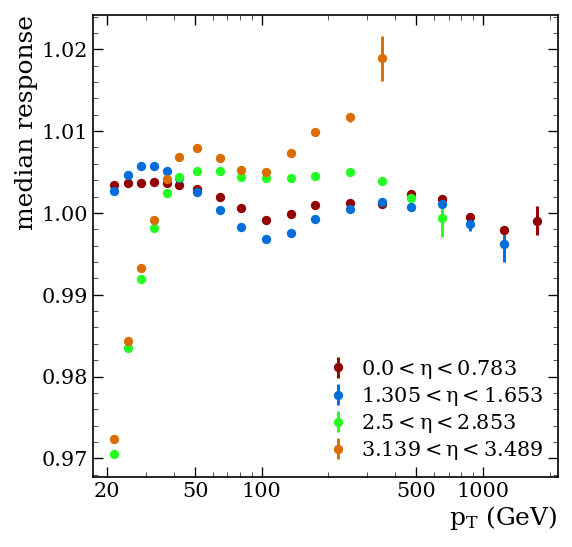

-------------------------
-------------------------
Fitting flavor:  all_minus_b
Response fits won't be saved
N converge =  280 N_not_converge =  0
Figure saved: fig/corr_vs_pt/Pythia-TTBAR/corr_vs_pt_Pythia-TTBAR_all_minus_b.pdf /.png


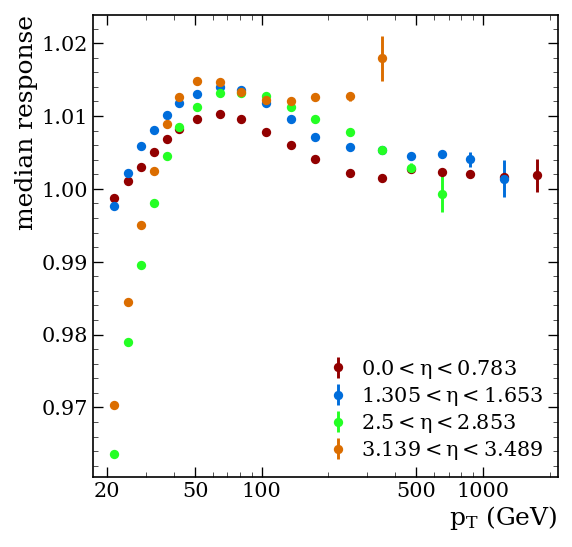

-------------------------
-------------------------
Fitting flavor:  b
Response fits won't be saved
N converge =  280 N_not_converge =  0
Figure saved: fig/corr_vs_pt/Pythia-TTBAR/corr_vs_pt_Pythia-TTBAR_b.pdf /.png


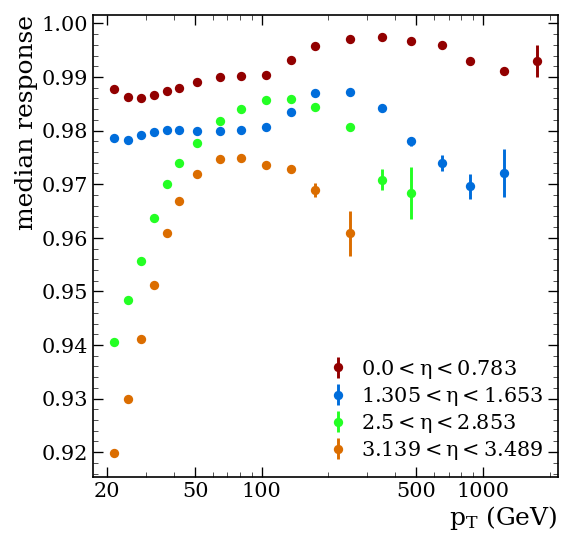

-------------------------
-------------------------
Fitting flavor:  all_unmatched
Response fits won't be saved
N converge =  280 N_not_converge =  0
Figure saved: fig/corr_vs_pt/Pythia-TTBAR/corr_vs_pt_Pythia-TTBAR_all_unmatched.pdf /.png


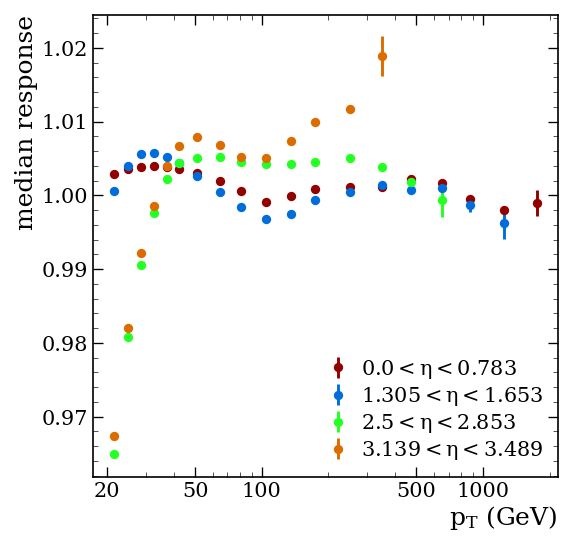

-------------------------
-------------------------
Fitting flavor:  unmatched
Response fits won't be saved
N converge =  262 N_not_converge =  18
Figure saved: fig/corr_vs_pt/Pythia-TTBAR/corr_vs_pt_Pythia-TTBAR_unmatched.pdf /.png


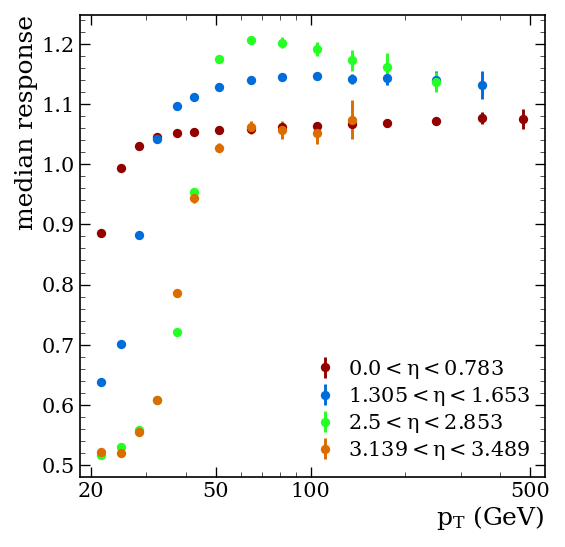

In [86]:
# %%time
# load_fit_res=False
combine_antiflavour = True
# flavors = ['b', 'c', 'u', 'd', 's', 'g', 'q', 'ud', 'all', 'unmatched']
flavors = ['all', 'all_minus_b', 'b' ,'all_unmatched', 'unmatched']
print('-'*25)
print('-'*25)
print(f'Starting to fit each flavor in: {flavors}')
for flav in flavors:
    print('-'*25)
    print('-'*25)
    print('Fitting flavor: ', flav)
    if load_fit_res:
        result = {}
        keys = ["Mean", "MeanVar", "Median", "MedianStd", "MeanRecoPt"] 
        for key in keys:
            result[key] = read_data(key, flav, tag_full)
    
    else:
        result = fit_responses(output, flav)
        medians.append(result["Median"][0][0])
        medianstds.append(result["MedianStd"][0][0])
        for key in result:
            save_data(result[key], key, flav, tag_full, ptbins, etabins_abs)
            pass
            
#     print("result = ", result)
    median = result["Median"]
    medianStd = result["MedianStd"]
    
    meanstd = np.sqrt(result["MeanVar"])
            
    if one_bin: #or fine_etabins:
        plot_corrections_eta(result["Median"], result["MedianStd"], ptbins, etabins_c, tag_full, flav)
    else:
        plot_corrections(result["Median"], result["MedianStd"], ptbins_c, etabins_abs, tag_full, flav)

In [145]:
print('-----'*10)
print("All done. Congrats!")

--------------------------------------------------
All done. Congrats!
